<a href="https://colab.research.google.com/github/prosvirinKir/Skoltech_IW/blob/main/QS_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

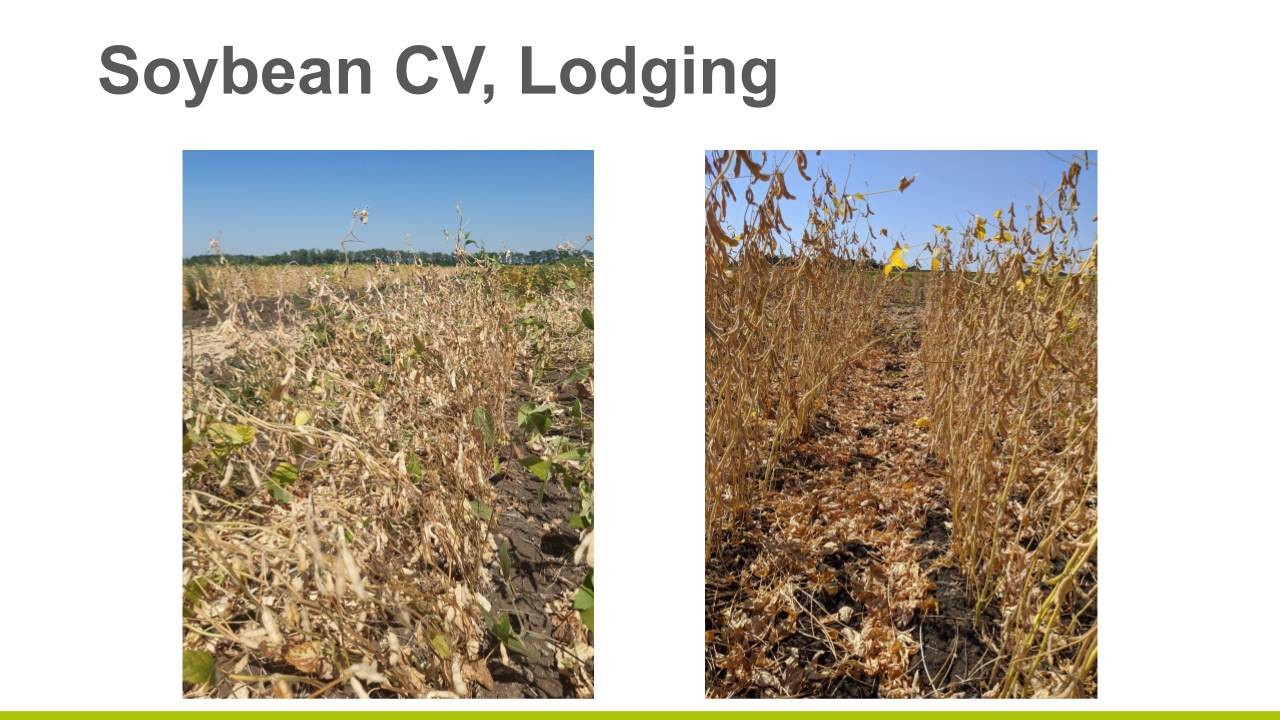

Today we will try to determine one of the phenotypic traits of soybeans - lodging.

Identify in the pictures above where the soybeans fell?

This task is essentially a classification task. 

It is necessary to divide the image into **2 groups: lodging and straightness**.

## Plan:
1. Upload dataset
2. Augmentation
3. Training & Validation

## Imports

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from IPython.display import clear_output 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms, utils, models
import torchvision.utils as vutils

from IPython.display import Image
import time
from pylab import rcParams

from tensorflow import summary


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.device_count())
torch.manual_seed(42)

cuda:0
1


Don't forget to add the folder shortcut to your google drive. 

Confirm access to your disk so Colab can download the data.

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Datasets, Augmentation

Instead of '/content/drive/MyDrive/data/scores.csv', enter the correct path to the folder on your drive.

In [4]:
scores = pd.read_csv('/content/drive/MyDrive/data/scores.csv') #change to correct directory
scores.head()

,growth,slope,hat,uniformity,score,sort
0,1,1,2,1,4,1_1
1,1,0,1,0,4,2_1
2,1,1,2,0,4,3_1
3,1,1,1,0,4,4_1
4,1,1,0,0,4,5_1


**Data Augmentation** is a technique that can be used to artificially expand the size of a training set by creating modified data from the existing one. 

It is a good practice to use DA if you want to prevent overfitting, or the 
initial dataset is too small to train on, or even if you want to squeeze better performance from your model.

To begin with, we expand the training set.

In [5]:
def load_train_dataset(data_path, batch_size, num_workers):
    dataset = datasets.ImageFolder(root=data_path,
                                   transform=transforms.Compose([transforms.Resize((256, 256)),
                                                                 transforms.RandomAffine(5, translate = (0.05, 0.1), 
                                                                                         scale = (0.9, 1.1), shear=(-5, 5)),
                                                                 # You can add your own transformations!
                                                                #  torchvision.transforms.Grayscale(num_output_channels=3),
                                                                 torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                                                 transforms.RandomHorizontalFlip(),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                      std=[0.229, 0.224, 0.225])
                                                                  ])
    )

    loader = torch.utils.data.DataLoader(dataset,
                                        batch_size=batch_size,
                                        num_workers=num_workers,
                                        shuffle=True
    )
    return loader

Then we bring the test sample to the same format. 

In [6]:
def load_val_dataset(data_path, batch_size, num_workers):
    dataset = datasets.ImageFolder(root=data_path,
                                   transform=transforms.Compose([transforms.Resize((256, 256)),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                      std=[0.229, 0.224, 0.225]),
                                                                #  torchvision.transforms.Grayscale(num_output_channels=3),
                                                                 
                                                                 transforms.RandomHorizontalFlip(),
                                      ])
    )
  
    loader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=True
    )
    return loader

## Data demo

Let's apply transformations to the data and see the result.

You should see 'growth	hat  scores.csv  uniformity' after the execution of the next cell.

In [7]:
!ls '/content/drive/MyDrive/data'

beans  lodging	scores.csv  uniformity


In [8]:
train_root_weed = '/content/drive/MyDrive/data/uniformity/train'
test_root_weed = '/content/drive/MyDrive/data/uniformity/test'
val_root_weed = '/content/drive/MyDrive/data/uniformity/val'

batch_size = 64
num_workers = 2

%time train_data_loader = load_train_dataset(train_root_weed, batch_size, num_workers)
%time val_data_loader = load_val_dataset(val_root_weed, batch_size, num_workers)
%time test_data_loader = load_val_dataset(test_root_weed, batch_size, num_workers)

CPU times: user 6.79 ms, sys: 3.19 ms, total: 9.98 ms
Wall time: 21.8 ms
CPU times: user 1.81 ms, sys: 986 µs, total: 2.8 ms
Wall time: 6.8 ms
CPU times: user 2.09 ms, sys: 1.09 ms, total: 3.18 ms
Wall time: 7.11 ms


torch.Size([64, 3, 256, 256])


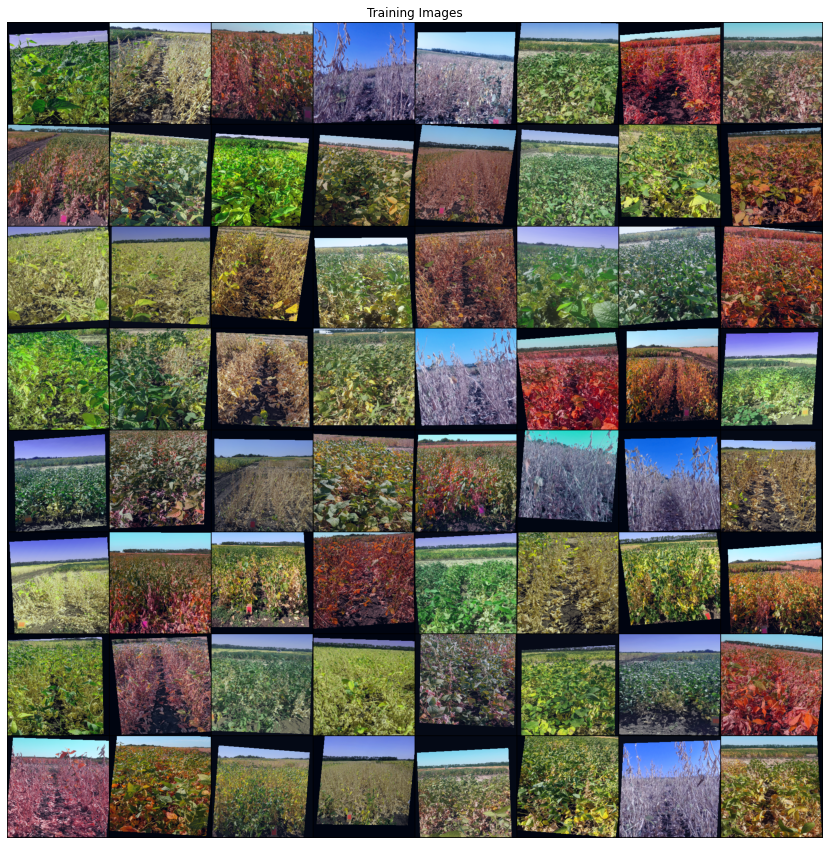

In [9]:
# batch = next(iter(train_data_loader))
# print (batch[0].shape)
# plt.figure(figsize=(15,15))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(vutils.make_grid(batch[0][:64], padding=2, normalize=True).permute((1, 2, 0)))

Formulate what are the restrictions for transformations due to the data format.

In [10]:
len(train_data_loader)

6

## Training & Validation

We can use weight initialization for our neural network.

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform_(m.weight.data)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.xavier_uniform_(m.weight.data)

We need this function to calculate overall accuracy. Fill the gap!

In [12]:
def get_accuracy(outputs, labels):
    _, argmax = torch.max(outputs, 1)
    return (labels == argmax.squeeze()).float().mean()

We will save the best trys.

In [13]:
def save_checkpoint(state, is_best, filename=''):
    if is_best:
        filename = filename+'model_best.pth.tar'        
        torch.save(state, filename)

Let's train our net!

In [14]:
def train(net, train_data_loader):
    net.train()
    running_loss = 0.
    running_accuracy = 0.
    
    for batch_idx, data in enumerate(train_data_loader):
        images, labels = data[0].type(torch.FloatTensor), data[1]
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)

        accuracy = get_accuracy(outputs, labels).item()
        running_accuracy += accuracy
        
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        
    running_accuracy /= len(train_data_loader)
    running_loss /= len(train_data_loader)
    print('Train set: Loss: {:.4f}, Accuracy: {:.2f}%)'.format(
        running_loss, 100 * running_accuracy))
    r_loss = running_loss
    r_acc = running_accuracy
    running_loss = 0.
    running_accuracy = 0.
    net.train()

    return r_loss, r_acc

Write the code for validation function by yourself!

In [15]:
def valid(net, val_data_loader):
    net.eval()
    running_val_loss = 0.
    running_val_accuracy = 0.


    ### Fill the gap
    with torch.no_grad():
        for batch_idx, data in enumerate(val_data_loader):
            images, labels = data[0].type(torch.FloatTensor), data[1]
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)

            accuracy = get_accuracy(outputs, labels).item()
            running_val_accuracy += accuracy
            
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    running_val_loss /= len(val_data_loader)
    running_val_accuracy /= len(val_data_loader)

    print('Valid set: Loss: {:.4f}, Accuracy: {:.2f}%)'.format(
        running_val_loss, 100 * running_val_accuracy))
    
    valid_loss = running_val_loss
    valid_accuracy = running_val_accuracy

    running_val_loss = 0.
    running_val_accuracy = 0.

    return valid_loss, valid_accuracy

Let's set our network.

In [16]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [17]:
# # Uniformity got 2 classes
# n_classes = 2

# # You can try other architectures
# net = torchvision.models.resnet18()
# num_ftrs = net.fc.in_features
# net.fc = nn.Linear(num_ftrs, n_classes)
# net = net.cuda()

In [ ]:
# model_resnet50 = models.resnet50(pretrained=True)
# n_classes = 2

# model_resnet50.fc = nn.Linear(2048, n_classes)
# net = model_resnet50.to(device)

In [18]:
# model_resnet50 = models.resnet50(pretrained=True)
# n_classes = 2

# model_resnet50.fc = nn.Linear(2048, n_classes)
# net = model_resnet50.to(device)

In [19]:
# model_resnet101 = models.resnet101(pretrained=True)
# n_classes = 2

# model_resnet101.fc = nn.Linear(2048, n_classes)
# net = model_resnet101.to(device)

In [20]:
# inception = models.inception_v3(pretrained=True)
# n_classes = 2
# inception.fc = nn.Linear(2048, n_classes)
# net = inception.to(device)

Hyperparameters setting. Experiment with it!

In [21]:
# Set learning rate parameter
lr = 3e-4

# Set loss
criterion = nn.CrossEntropyLoss().to(device)

# Set optimizer
optimizer = optim.Adam(net.parameters(), lr=lr)

# Set schefuler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.3)
#net.apply(weights_init)

Woohoo, almost done! Let's train this bad boy!

In [22]:
epochs = 5
best_accuracy = 0
_time = time.time()
globaliter = 0

train_losses = []
val_losses = []
train_acc = []
val_acc = []

for epoch in range(1, epochs+1):

    print("Epoch:", epoch)
    running_loss, running_accuracy = train(net, train_data_loader)
    train_losses.append(running_loss)
    train_acc.append(running_accuracy)

    print("Time:", time.time() - _time, '\n')
    if (epoch % 1 == 0):
        loss, accuracy = valid(net, val_data_loader)
        val_losses.append(loss)
        val_acc.append(accuracy)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            is_best = True
        else:
            is_best = False
        save_checkpoint({
            'epoch': epoch,
            'state_dict': net.state_dict(),
            'best_prec1': accuracy,
            'optimizer': optimizer.state_dict(),
        }, is_best, filename = 'Slope' + net.__class__.__name__+" "+str(lr))
    scheduler.step()
print("Best ", best_accuracy) 

Epoch: 1


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train set: Loss: 0.5586, Accuracy: 70.66%)
Time: 80.52834796905518 

Valid set: Loss: 0.5610, Accuracy: 80.99%)
Epoch: 2
Train set: Loss: 0.4043, Accuracy: 86.02%)
Time: 188.39808249473572 

Valid set: Loss: 0.5442, Accuracy: 82.03%)
Epoch: 3
Train set: Loss: 0.3253, Accuracy: 84.03%)
Time: 295.9544005393982 

Valid set: Loss: 0.7225, Accuracy: 81.25%)
Epoch: 4
Train set: Loss: 0.3637, Accuracy: 83.85%)
Time: 402.39498925209045 

Valid set: Loss: 0.6471, Accuracy: 80.21%)
Epoch: 5
Train set: Loss: 0.3686, Accuracy: 80.90%)
Time: 509.41863083839417 

Valid set: Loss: 0.6290, Accuracy: 80.47%)
Best  0.8203125


In [23]:
sns.set(style="whitegrid", font_scale=1.4)

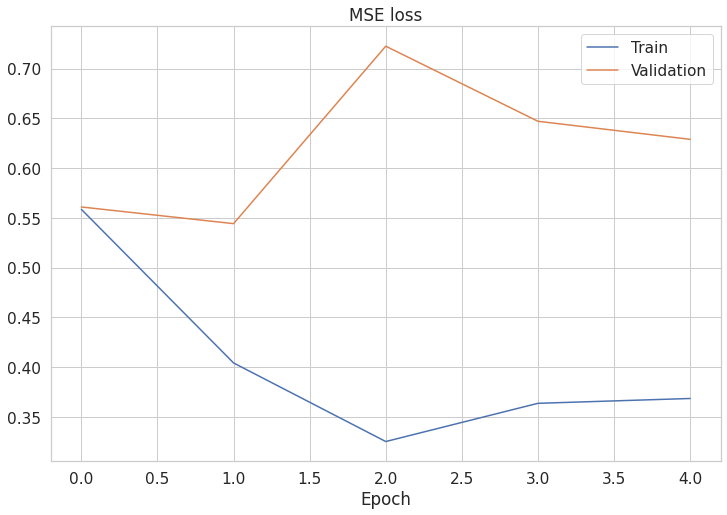

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

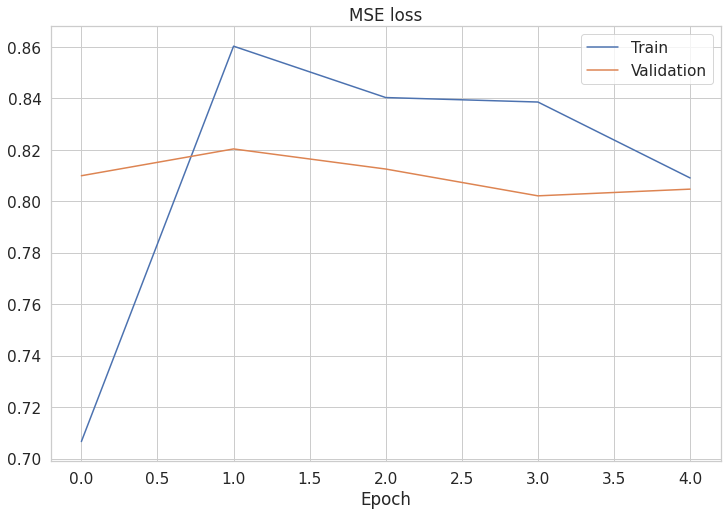

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(train_acc)), train_acc, label='Train')
plt.plot(np.arange(len(val_acc)), val_acc, label='Validation')

plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

**Try to beat 89% test accuracy!**

Bonus task! Do lodging phen